In [1]:
import os
import copy
import functools
from collections import defaultdict

import lmfit
import corner
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy.stats import linregress
from matplotlib.ticker import MultipleLocator
from lmfit import Parameter, Parameters 

import sivqed.models.fitter as fitter
from sivqed.models.cavity import Cavity, MultiQubitCavity
from sivqed.models.fitter import cavity_ref_model, single_siv_ref_model, mcmc
from sivqed.models.diffusion import diffused_siv_peaks, plot_diffused_contrasts

np.set_printoptions(precision=4)
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = [8, 5]

In [2]:
data_path = "../data/20210429_B16_SiV/"

cavity_files = ["bb2_raw-counts_x_14_23_44.txt", "bb2_raw-counts_14_23_44.txt"]
siv_files = [["sweeper_fwd_avg_15_19_21.txt", "sweeper_fwd_scans_15_19_19.txt"],
             ["sweeper_fwd_avg_15_25_01.txt", "sweeper_fwd_scans_15_25_00.txt"],
             ["sweeper_fwd_avg_15_49_44.txt", "sweeper_fwd_scans_15_49_43.txt"]]

# Plot data

## Plot Cavity Data

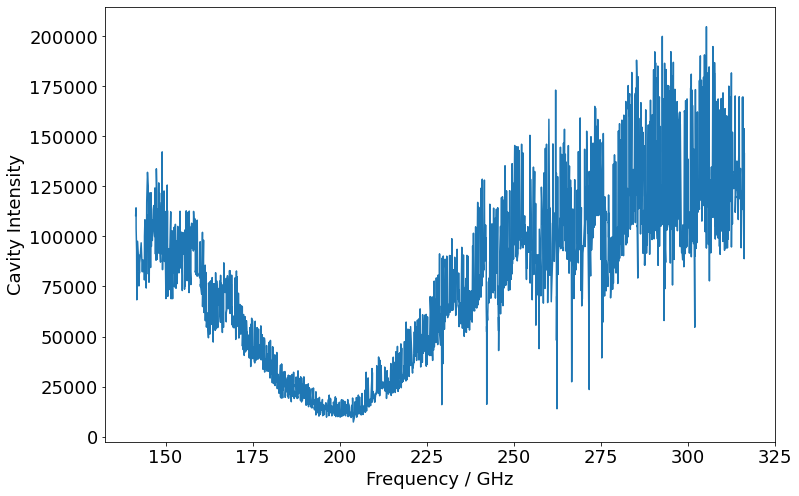

In [3]:
plt.figure(figsize=[12, 8])

cavity_freqs = np.loadtxt(data_path + cavity_files[0])
cavity_intensity = np.loadtxt(data_path + cavity_files[1])

cavity_freqs = cavity_freqs * (cavity_freqs - 406) # Re-center, convert to GHz
plt.plot(cavity_freqs, cavity_intensity)
plt.xlabel("Frequency / GHz")
plt.ylabel("Cavity Intensity")

# Sort by frequency values
cavity_freqs, cavity_intensity = np.array(cavity_freqs), np.array(cavity_intensity)

## Plot SiV Data

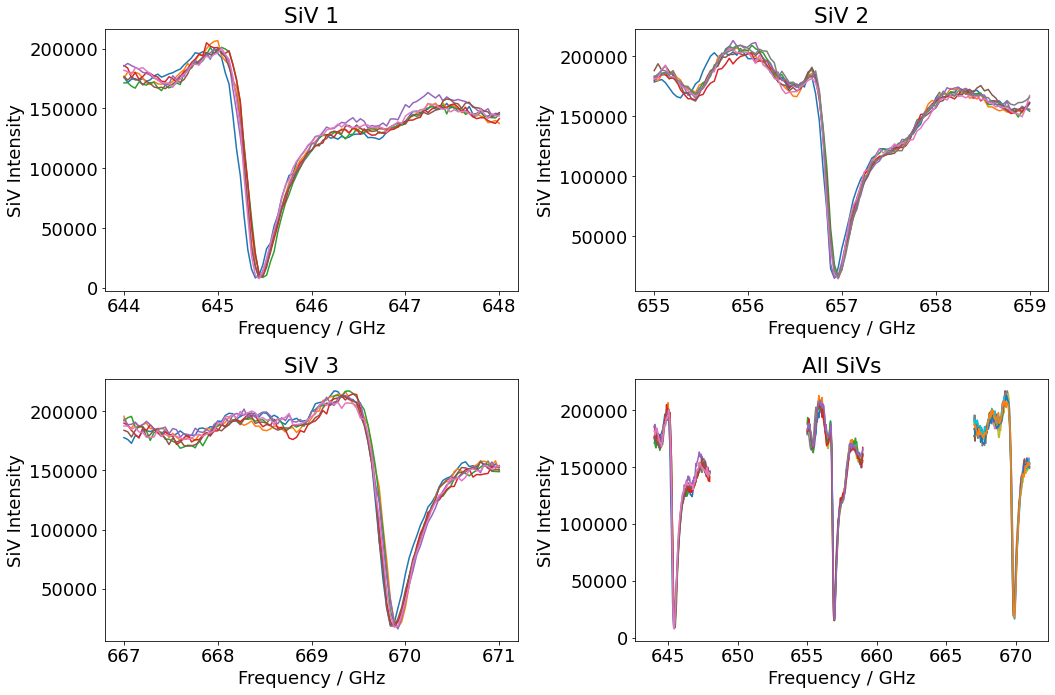

In [4]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=[15, 10])

for idx, siv_files_tuple in enumerate(siv_files):
    # Extract freq from the avg scan file
    siv_freqs, _ = np.loadtxt(data_path + siv_files_tuple[0])
    siv_freqs = 1000 * (siv_freqs - 406)

    # Extract data from the SiV scan file
    siv_data = np.loadtxt(data_path + siv_files_tuple[1])

    for siv_series in siv_data:
        ax[idx//2, idx%2].plot(siv_freqs, siv_series)
        ax[1, 1].plot(siv_freqs, siv_series)

for idx in range(4):
    axes = ax[idx//2, idx%2]
    axes.set_xlabel("Frequency / GHz")
    axes.set_ylabel("SiV Intensity")
    if idx != 3: 
        axes.set_title(f"SiV {idx+1}")
    else:
        axes.set_title(f"All SiVs")
        
fig.tight_layout()

# --------------------
# Fit Cavity Spectrum

### Unfiltered

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 2812
    # variables        = 4
    chi-square         = 1.0230e+12
    reduced chi-square = 3.6430e+08
    Akaike info crit   = 55438.3406
    Bayesian info crit = 55462.1072
[[Variables]]
    w_c:    199.952931 +/- 0.27015975 (0.14%) (init = 200)
    k_in:   25.0306609 +/- 0.65106168 (2.60%) (init = 30)
    k_tot:  38.8582792 +/- 0.76774224 (1.98%) (init = 50)
    A:      143234.235 +/- 1214.44476 (0.85%) (init = 200000)
    B:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, k_tot) =  0.963
    C(k_tot, A)    =  0.823
    C(k_in, A)     =  0.712
    C(w_c, A)      =  0.118


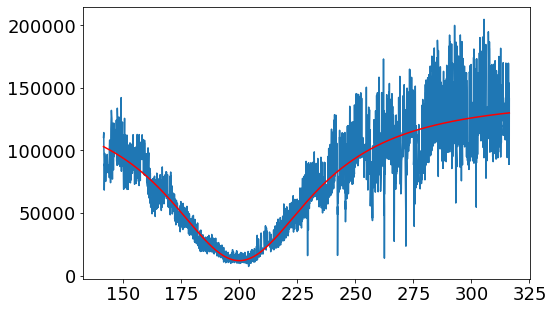

In [111]:
params = Parameters()
params.add_many(
    Parameter('w_c', value=200, min=190, max=210),
    Parameter('k_in', value=30, min=0, max=1000),
    Parameter('k_tot', value=50, min=0, max=1000),
    Parameter('A', value=200000, min=100000, max=500000),
    Parameter('B', value=0, vary=False),
)

cavity_results = cavity_ref_model.fit(cavity_intensity, params, w=cavity_freqs)
lmfit.report_fit(cavity_results)

plt.plot(cavity_freqs, cavity_intensity)
plt.plot(cavity_freqs, cavity_ref_model.eval(params=cavity_results.params, w=cavity_freqs), 'r')

fit_ratio = cavity_intensity / cavity_ref_model.eval(params=cavity_results.params, w=cavity_freqs)

100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [01:25<00:00, 70.51it/s]


Autocorrelation times: [43.5683 51.804  51.7102 51.6777 57.011 ]
Max 50 x Autocorrelation times: 2850.5512959777166

Median of posterior probability distribution
--------------------------------------------
[[Variables]]
    w_c:        199.955134 +/- 0.27187759 (0.14%) (init = 199.9529)
    k_in:       25.0419683 +/- 0.65115345 (2.60%) (init = 25.03066)
    k_tot:      38.8844073 +/- 0.76854574 (1.98%) (init = 38.85828)
    A:          143280.586 +/- 1225.69575 (0.86%) (init = 143234.2)
    B:          0 (fixed)
    __lnsigma:  9.85675296 +/- 0.01322028 (0.13%) (init = 10.81978)
[[Correlations]] (unreported correlations are < 0.400)
    C(k_in, k_tot) =  0.962
    C(k_tot, A)    =  0.824
    C(k_in, A)     =  0.712

Maximum Likelihood Estimation from emcee       
-------------------------------------------------
Parameter  MLE Value   Median Value   Uncertainty
  w_c      199.97811   199.95513       0.27188
  k_in      25.04997    25.04197       0.65115
  k_tot     38.86797    38.8844

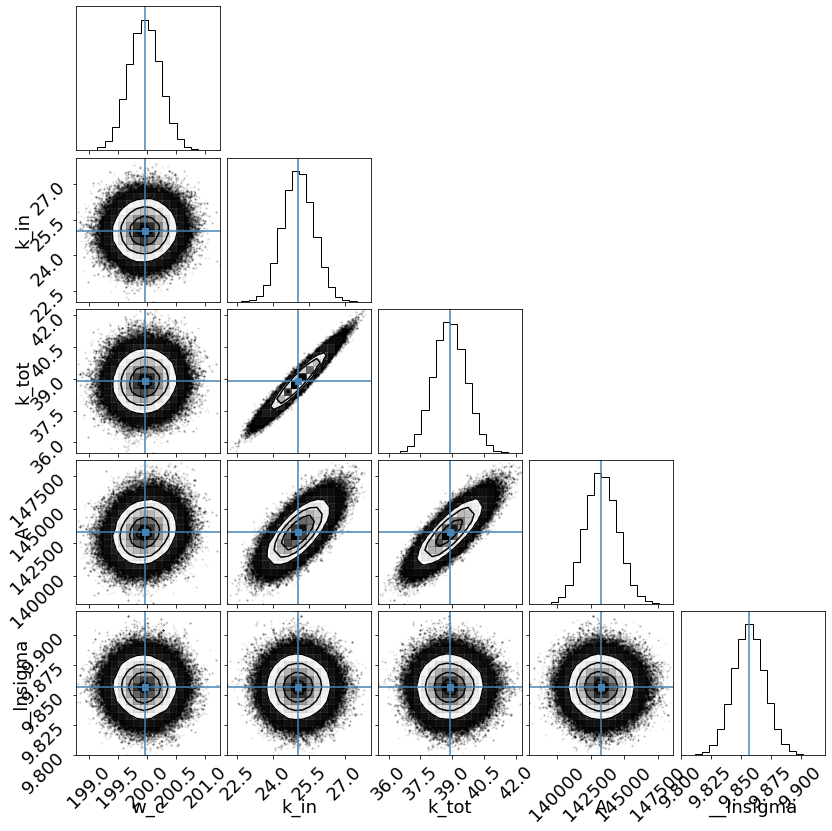

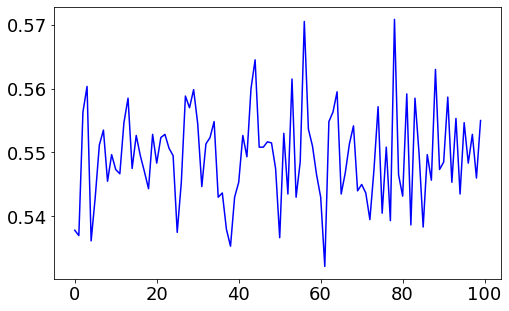

In [6]:
# Compute the correlations and error in the fits using MCMC
# data_noise is a 3-tuple (expected noise in data, min estimate, max estimate)
emcee_results, emcee_mle_params = mcmc(cavity_freqs, cavity_intensity, cavity_ref_model, cavity_results, 
                                       data_noise=[50000, 10000, 200000], input_params={"steps": 6000})

### Filtered Cavity

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 1409
    # variables        = 4
    chi-square         = 1.7425e+11
    reduced chi-square = 1.2402e+08
    Akaike info crit   = 26262.0481
    Bayesian info crit = 26283.0507
[[Variables]]
    w_c:    199.726225 +/- 0.20804171 (0.10%) (init = 200)
    k_in:   23.8650118 +/- 0.49290762 (2.07%) (init = 30)
    k_tot:  37.1855508 +/- 0.63360012 (1.70%) (init = 50)
    A:      139750.556 +/- 1268.39122 (0.91%) (init = 200000)
    B:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, k_tot) =  0.972
    C(k_tot, A)    =  0.784
    C(k_in, A)     =  0.687
    C(w_c, k_tot)  =  0.340
    C(w_c, k_in)   =  0.322
    C(w_c, A)      =  0.101


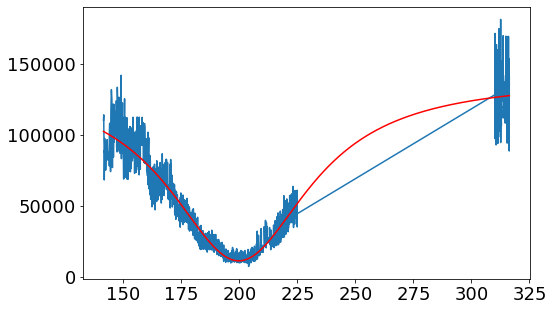

In [101]:
def not_in_range(arr, ranges):
    """ Returns indices of `arr` that do not lie in the list 
        of (start, end) tuples in ranges. """
    
    conditions = []
    # AND of (x < start OR x > end) leads to all x that are 
    # outside of the (start, end) ranges.
    for start, end in ranges:
        conditions.append((arr < start) | (arr > end)) 
    return np.where(functools.reduce(np.logical_and, conditions))

# Range of frequencies to filter out to remove SiV peaks
filter_range = [(225, 310)]

# Filter the freq and intensity values
filtered_indices = not_in_range(cavity_freqs, filter_range)
cavity_freqs_filtered = cavity_freqs[filtered_indices]
cavity_intensity_filtered = cavity_intensity[filtered_indices]

#####
params = Parameters()
params.add_many(
    Parameter('w_c', value=200, min=190, max=210),
    Parameter('k_in', value=30, min=0, max=1000),
    Parameter('k_tot', value=50, min=0, max=1000),
    Parameter('A', value=200000, min=100000, max=500000),
    Parameter('B', value=0, vary=False),
)

cavity_filtered_results = cavity_ref_model.fit(cavity_intensity_filtered, params, w=cavity_freqs_filtered)
lmfit.report_fit(cavity_filtered_results)

plt.plot(cavity_freqs_filtered, cavity_intensity_filtered)
plt.plot(cavity_freqs, cavity_ref_model.eval(params=cavity_filtered_results.params, w=cavity_freqs), 'r')

fit_ratio = cavity_intensity_filtered / cavity_ref_model.eval(params=cavity_filtered_results.params, w=cavity_freqs_filtered)

# Fit SiV Spectrum

## Fit SiV 1

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 132
    # data points      = 101
    # variables        = 5
    chi-square         = 2.3500e+09
    reduced chi-square = 24478657.1
    Akaike info crit   = 1723.21652
    Bayesian info crit = 1736.29213
[[Variables]]
    w_up:      645.147427 +/- 0.01117200 (0.00%) (init = 645.5)
    g_up:      4.14267133 +/- 0.14548330 (3.51%) (init = 5.6)
    gamma_up:  0.05 (fixed)
    w_c:       585.311259 +/- 1.83671668 (0.31%) (init = 715)
    k_in:      19.9902190 +/- 0.76950609 (3.85%) (init = 25)
    k_tot:     38.87 (fixed)
    A:         222025.681 +/- 3408.26139 (1.54%) (init = 200000)
    B:         0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(w_c, A)     =  0.973
    C(g_up, w_c)  = -0.960
    C(w_up, g_up) = -0.923
    C(g_up, A)    = -0.923
    C(w_up, w_c)  =  0.819
    C(w_up, A)    =  0.785
    C(w_up, k_in) =  0.765
    C(g_up, k_in) = -0.624
    C(k_in, A)    =  0.562
    C(w_c, 

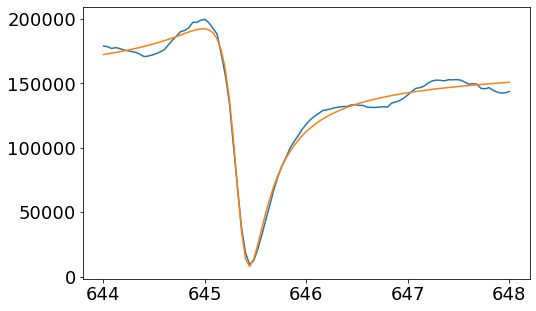

In [113]:
siv_index = 1
siv_files_tuple = siv_files[siv_index - 1] 

# Extract freq from the avg scan file
siv1_freqs, siv1_mean = np.loadtxt(data_path + siv_files_tuple[0])
siv1_freqs = 1000 * (siv1_freqs - 406)

params = Parameters()
params.add_many(
    Parameter('w_up', value=645.5, min=645, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.05, vary=False),
    Parameter('w_c', value=715, min=0, max=1000),
    Parameter('k_in', value=25, min=0, max=38),
    Parameter('k_tot', value=38.87, vary=False),
    Parameter('A', value=200000, min=5000, max=900000),
    Parameter('B', value=0, vary=False),
)

siv1_results = single_siv_ref_model.fit(siv1_mean, params, w=siv1_freqs)
lmfit.report_fit(siv1_results)

plt.plot(siv1_freqs, siv1_mean)
plt.plot(siv1_freqs, single_siv_ref_model.eval(siv1_results.params, w=siv1_freqs))

## Fit SiV 2

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 106
    # data points      = 101
    # variables        = 5
    chi-square         = 1.0564e+10
    reduced chi-square = 1.1004e+08
    Akaike info crit   = 1875.02474
    Bayesian info crit = 1888.10034
[[Variables]]
    w_up:      656.636161 +/- 0.03051682 (0.00%) (init = 656.9)
    g_up:      5.16783658 +/- 0.42754884 (8.27%) (init = 5.6)
    gamma_up:  0.05 (fixed)
    w_c:       574.222590 +/- 5.74493194 (1.00%) (init = 715)
    k_in:      18.4624866 +/- 1.38398739 (7.50%) (init = 25)
    k_tot:     38.87 (fixed)
    A:         210755.018 +/- 4726.16032 (2.24%) (init = 200000)
    B:         0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(w_c, A)     =  0.947
    C(g_up, w_c)  = -0.942
    C(w_up, g_up) = -0.935
    C(g_up, A)    = -0.897
    C(w_up, w_c)  =  0.781
    C(w_up, A)    =  0.757
    C(w_up, k_in) =  0.708
    C(g_up, k_in) = -0.543
    C(k_in, A)    =  0.423
    C(w_c, 

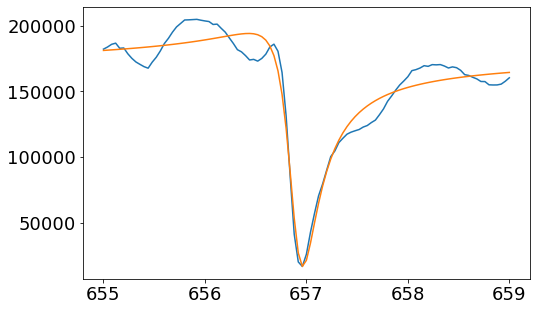

In [95]:
siv_index = 2
siv_files_tuple = siv_files[siv_index - 1] 

# Extract freq from the avg scan file
siv2_freqs, siv2_mean = np.loadtxt(data_path + siv_files_tuple[0])
siv2_freqs = 1000 * (siv2_freqs - 406)

params = Parameters()
params.add_many(
    Parameter('w_up', value=656.9, min=656, max=657.5),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.05, vary=False),
    Parameter('w_c', value=715, min=0, max=1000),
    Parameter('k_in', value=25, min=0, max=38),
    Parameter('k_tot', value=38.87, vary=False),
    Parameter('A', value=200000, min=5000, max=900000),
    Parameter('B', value=0, vary=False),
)

siv2_results = single_siv_ref_model.fit(siv2_mean, params, w=siv2_freqs)
lmfit.report_fit(siv2_results)

plt.plot(siv2_freqs, siv2_mean)
plt.plot(siv2_freqs, single_siv_ref_model.eval(siv2_results.params, w=siv2_freqs))

## Fit SiV 3

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 153
    # data points      = 101
    # variables        = 5
    chi-square         = 2.5343e+09
    reduced chi-square = 26399212.9
    Akaike info crit   = 1730.84532
    Bayesian info crit = 1743.92092
[[Variables]]
    w_up:      669.549080 +/- 0.01156626 (0.00%) (init = 669.8)
    g_up:      4.86657013 +/- 0.15534209 (3.19%) (init = 5.6)
    gamma_up:  0.05 (fixed)
    w_c:       595.918157 +/- 2.09147927 (0.35%) (init = 715)
    k_in:      18.1262940 +/- 0.60581179 (3.34%) (init = 25)
    k_tot:     38.87 (fixed)
    A:         224860.970 +/- 2470.44352 (1.10%) (init = 200000)
    B:         0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(w_c, A)     =  0.942
    C(g_up, A)    = -0.916
    C(g_up, w_c)  = -0.916
    C(w_up, g_up) = -0.894
    C(w_up, A)    =  0.734
    C(w_up, k_in) =  0.699
    C(w_up, w_c)  =  0.669
    C(g_up, k_in) = -0.471
    C(k_in, A)    =  0.377
    C(w_c, 

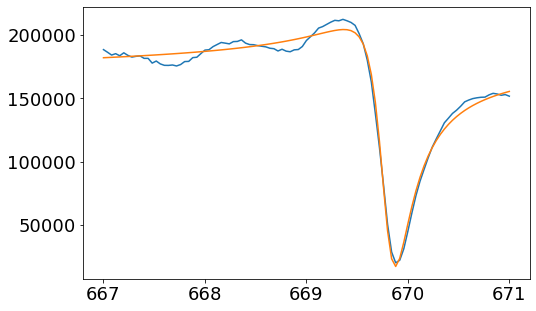

In [28]:
siv_index = 3
siv_files_tuple = siv_files[siv_index - 1] 

# Extract freq from the avg scan file
siv2_freqs, siv2_mean = np.loadtxt(data_path + siv_files_tuple[0])
siv2_freqs = 1000 * (siv2_freqs - 406)

params = Parameters()
params.add_many(
    Parameter('w_up', value=669.8, min=669, max=670.5),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.05, vary=False),
    Parameter('w_c', value=715, min=0, max=1000),
    Parameter('k_in', value=25, min=0, max=38),
    Parameter('k_tot', value=38.87, vary=False),
    Parameter('A', value=200000, min=5000, max=900000),
    Parameter('B', value=0, vary=False),
)

siv3_results = single_siv_ref_model.fit(siv2_mean, params, w=siv2_freqs)
lmfit.report_fit(siv3_results)

plt.plot(siv2_freqs, siv2_mean)
plt.plot(siv2_freqs, single_siv_ref_model.eval(siv3_results.params, w=siv2_freqs))

# Measure SiV contrast

In [130]:
# Average estimate of parameters from SiV 
cavity_res_freq = np.mean([siv1_results.params["w_c"].value, siv2_results.params["w_c"].value, siv3_results.params["w_c"].value])
siv_scaling = np.mean([siv1_results.params["A"].value, siv2_results.params["A"].value, siv3_results.params["A"].value])
k_in = np.mean([siv1_results.params["k_in"].value, siv2_results.params["k_in"].value, siv3_results.params["k_in"].value])
g_up = np.mean([siv1_results.params["g_up"].value, siv2_results.params["g_up"].value, siv3_results.params["g_up"].value])

Text(0, 0.5, 'SiV Peak Contrast')

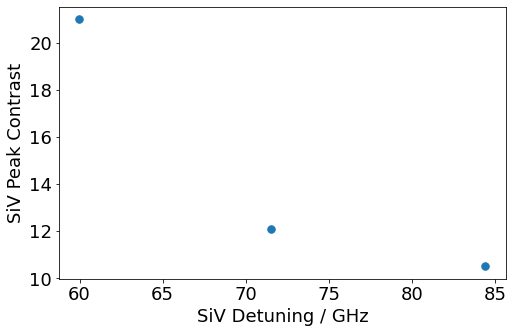

In [116]:
# Array of SiV resonance freqs
siv_res_freqs = np.array([siv1_results.params["w_up"].value, siv2_results.params["w_up"].value, siv3_results.params["w_up"].value])
# Array of SiV detunings
siv_res_detunings = siv_res_freqs - cavity_res_freq 

siv_min_dips = []
siv_contrasts = []
for siv_files_tuple in siv_files:
    # Get the mean from the avg scan
    _, siv_mean = np.loadtxt(data_path + siv_files_tuple[0])
    siv_min_dips.append(min(siv_mean))
    siv_contrasts.append(max(siv_mean) / min(siv_mean))

plt.plot(siv_res_detunings, siv_contrasts, '.', ms=15)    
plt.xlabel("SiV Detuning / GHz")
plt.ylabel("SiV Peak Contrast")

### Compare against simulated diffused SiV 

In [128]:
# Diffusion stdev list
diffusion_stdev_list = np.geomspace(5e-3, 10, 8)
# List of SiV detunings to iterate over
detuning_freqs = np.linspace(-250, 250, 1000)

# Cavity parameters taken from cavity and SiV estimates
# w_up will be varied by diffused_siv_peaks()
c = Cavity({"w_c" : 0, "k_in" : k_in, "k_tot" : 38.87}, 
           {"w_up" : 0, "g_up" : g_up, "gamma_up" : 0.05})

# Stores the simulated diffused SiV min/max values
diffused_siv_min_list = []
diffused_siv_max_list = []

# Compute the siv min/max for clean and diffused!
for diffusion_stdev in diffusion_stdev_list:
    siv_min, siv_max, diffused_siv_min, diffused_siv_max = diffused_siv_peaks(c, detuning_freqs, diffusion_stdev, plot=False)
    diffused_siv_min_list.append(diffused_siv_min)
    diffused_siv_max_list.append(diffused_siv_max)
    
diffused_siv_min_list = np.array(diffused_siv_min_list)
diffused_siv_max_list = np.array(diffused_siv_max_list)

The current value of diffusion of 0.005 requires 30000 freq steps.
The current value of diffusion of 0.014809681479725867 requires 10128 freq steps.


(0.0, 25.0)

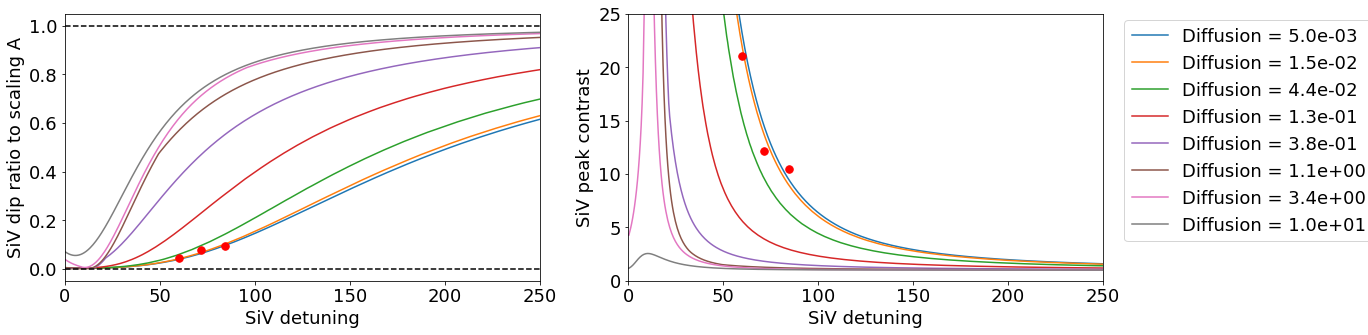

In [131]:
# Plot simulated diffused SiV contrasts and dip ratio
# NOTE: we don't have the cavity dip (since cavity was measured with a diff instrument) so we instead compare against 1,
# which is the unperturbed cavity value (i.e. is the scaling constant A)
fig, ax = plot_diffused_contrasts(detuning_freqs, diffusion_stdev_list, diffused_siv_min_list, diffused_siv_max_list, cavity_min=1)

# Overlay experimental values. 
# NOTE: Here we scale the SiV to the unperturbed value, i.e. the scaling constant A
ax[0].plot(siv_res_detunings, siv_min_dips / siv_scaling, 'r.', ms=15)
ax[0].set_ylabel("SiV dip ratio to scaling A")
ax[1].plot(siv_res_detunings, siv_contrasts, 'r.', ms=15) 
ax[1].set_ylim(0, 25)